
# **DI 725: Transformers and Attention-Based Deep Networks Term Project**  
## Efficient Adaptation of PaliGemma for Remote Sensing Image Captioning Using LoRA
### Turkan Simge Ispak - 2701795
---

## Introduction

Remote sensing image captioning is the task of automatically generating descriptive text for satellite or aerial imagery. It enables semantic interpretation of geospatial scenes—useful in fields like environmental monitoring, disaster response, and urban planning.

This project explores the **parameter-efficient fine-tuning** of the **PaliGemma-3B** vision-language model on the **RSICD** dataset, which consists of 44,521 satellite images with 5 human-written captions per image.

Due to compute and data limitations, we adopt a combination of:
- **LoRA (Low-Rank Adaptation):** to inject minimal trainable weights into selected layers.
- **QLoRA (4-bit Quantization):** to reduce memory usage.
- **Tiered Progressive Grid Search:** to systematically identify optimal LoRA configurations across architecture, hyperparameters, and training duration.

The final model outperforms the zero-shot baseline across all metrics (BLEU, METEOR, ROUGE-L), proving that even large models can be adapted efficiently in domain-specific, low-resource settings.



**Environment Setup**

To run the fine-tuning and evaluation process efficiently on consumer-grade GPUs, we rely on a small set of specialized Python libraries:

- `bitsandbytes`: Enables **4-bit quantization** of model weights (QLoRA) for memory-efficient training.
- `transformers`: Core Hugging Face library to load the **PaliGemma** model and related utilities.
- `datasets`: Provides easy access to the **RSICD** dataset and other evaluation data.
- `peft`: Implements **Parameter-Efficient Fine-Tuning (PEFT)** methods such as LoRA.
- `rouge_score`: Computes **ROUGE-L**, a common recall-based metric for captioning.
- `evaluate`: Wraps popular evaluation metrics (BLEU, METEOR, ROUGE) for easy integration with `datasets`.

Install all required packages below. Some are used for model adaptation (like `peft` and `transformers`), while others are for scoring and progress tracking.


In [ ]:
!pip install -q -U bitsandbytes

In [ ]:
!pip install -q -U transformers datasets peft bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b7fac30305df5498fb1ea074698555bc1950fcf2f25e1f528f8a464ae3e597b5
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


**Library Imports**  
- `torch`: tensor operations  
- `os`: environment variable access  
- `requests`: HTTP requests for image and dataset access  
- `PIL.Image`: image loading and manipulation  
- `matplotlib.pyplot`: optional visualization  
- `tqdm`: progress bars for loops  
- `datasets.load_dataset`: load datasets from Hugging Face  
- `evaluate.load`: evaluation metric utilities  

**Transformers**  
- `AutoProcessor`, `PaliGemmaProcessor`: preprocessing for image and text  
- `PaliGemmaForConditionalGeneration`: pre-trained PaliGemma model  
- `Trainer`, `TrainingArguments`: training utilities  
- `BitsAndBytesConfig`: quantization config for efficient training/inference  

**PEFT (Parameter-Efficient Fine-Tuning)**  
- `get_peft_model`, `LoraConfig`: enable QLoRA-based fine-tuning


**Library Imports**  
- `torch`: tensor operations  
- `requests`: fetch images via HTTP  
- `PIL.Image`: image loading and manipulation  
- `transformers.AutoProcessor`, `PaliGemmaForConditionalGeneration`: load and run PaliGemma

In [ ]:
# Core libraries
import os
import torch
import requests
from PIL import Image
import matplotlib.pyplot as plt
import time
import json
from torch.utils.data import DataLoader

# Hugging Face Transformers
from transformers import (
    AutoProcessor,
    PaliGemmaForConditionalGeneration,
    PaliGemmaProcessor,
    Trainer,
    TrainingArguments,
    BitsAndBytesConfig
)

# PEFT (Parameter-Efficient Fine-Tuning)
from peft import get_peft_model, LoraConfig

# Hugging Face datasets & evaluation
from datasets import load_dataset
from evaluate import load

# Progress bar
from tqdm import tqdm
from datetime import datetime
import itertools


**Hugging Face Login**  
- `notebook_login` from `huggingface_hub`: authenticates your account in notebooks  
- Prompts for Hugging Face token to access models and datasets

**WANDB Login**  
- `wandb.login()`: logs into Weights & Biases for experiment tracking  
- `os.environ["WANDB_API_KEY"]`: sets API key directly (optional alternative to manual login)


In [ ]:
from huggingface_hub import login
login(token = "HF_API_HERE")

In [ ]:
import wandb
os.environ["WANDB_API_KEY"] = "WANDB_API_HERE"
wandb.login()

wandb: Currently logged in as: turkanispak (turkanispak-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Baseline PaliGemma for RISCM Dataset Visual Question Answering

## Overall View
**Load Model, Image & Run Inference**  
- `model_id`: selects PaliGemma-3B (224px) from Hugging Face  
- `AutoProcessor.from_pretrained`: loads pre/post-processing logic for image + text  
- `PaliGemmaForConditionalGeneration.from_pretrained`: loads the pre-trained VLM

**Prompt & Image Setup**  
- Define a text `prompt` and a dataset (`image_file`)  
- Use `requests` + `PIL.Image` to download and open the image  
- Process both inputs using the processor; return PyTorch tensors

**Generate & Decode Output**  
- Call `generate` with inputs; limit to `max_new_tokens=20`  
- Use `processor.decode` to convert output tokens into readable text  
- Skip special tokens and trim the prompt from the output

**Reference** This notebook is based on the reference content of DI 725 Course `qlora-fine-tuning-with-full-risc.ipynb`

**Load and Split RISCM Dataset**

- `load_dataset(...)`: loads the full RISCM dataset
- `to_pandas()`: converts the full dataset to a DataFrame for inspection
- - `train_test_split(test_size=0.2)`: splits the dataset into 80% train and 20% test  


In [ ]:
ds = load_dataset('caglarmert/full_riscm')
ds_dataframe = ds['train'].to_pandas()

split_ds = ds["train"].train_test_split(test_size=0.2)
train_ds = split_ds["train"]
test_ds = split_ds["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/482 [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/384M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/358M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/375M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44521 [00:00<?, ? examples/s]

**Initialize Processor & Define Collate Function**  
- `PaliGemmaProcessor.from_pretrained(...)`: loads tokenizer + image processor  
- `collate_fn(...)`: prepares a batch of examples for model input  
  - Builds text prompts with `<image> <bos> describe this image.`  
  - Uses `caption_1` as target label  
  - Converts images to RGB  
  - Processes text, images, and labels using the processor  
  - Pads to the longest sequence, converts to `bfloat16`, moves to GPU  
  - Returns tokenized batch for model input


In [ ]:
device = "cuda"
model_id = "google/paligemma-3b-pt-224"

processor = AutoProcessor.from_pretrained(model_id)
pretrained_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id)
model = pretrained_model

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
def collate_fn(examples):
    texts = ["<image> <bos> describe this image." for _ in examples]
    labels = [example["caption_1"] for example in examples]
    images = [example["image"].convert("RGB") for example in examples]
    tokens = processor(text=texts, images=images, suffix=labels,
                       return_tensors="pt", padding="longest")
    tokens = tokens.to(torch.bfloat16).to(device)
    return tokens


**Baseline Inference & Evaluation Logging**

- `wandb.init(...)`: starts a Weights & Biases run to log metrics and samples  
- `start_time = time.time()`: tracks total elapsed inference time  

**Metric Setup**  
- `evaluate.load(...)`: loads BLEU, METEOR, and ROUGE scoring functions  

**Inference Loop**  
- Uses a fixed prompt: `<image> <bos> describe this image.`  
- For each sample in `test_ds`:  
  - Converts the image to RGB  
  - Extracts ground truth caption (`caption_1`)  
  - Preprocesses image + prompt using the processor  
  - Runs model inference (`generate(...)`)  
  - Decodes and stores the generated caption  

**Metric Computation**  
- `bleu.compute(...)`: evaluates BLEU-4 score (with reference wrapping)  
- `meteor.compute(...)`, `rouge.compute(...)`: compute respective scores  
- Metrics are logged to `wandb` along with total elapsed time  

**Sample Visualization**  
- Logs 5 image-caption pairs to `wandb` with both ground truth and prediction shown in the caption  
- Ends the wandb run with `wandb.finish()`


In [ ]:
# Init wandb
wandb.init(project="remote-sense-caption", name="baseline-inference-full-riscm", job_type="inference")

# Start timer
start_time = time.time()

# Load metrics
bleu = load("bleu")
meteor = load("meteor")
rouge = load("rouge")

# Run inference and accumulate predictions
generated_captions = []
references = []

prompt = "<image> <bos> describe this image."

batch_size = 32
model.eval()
with torch.inference_mode():
    for i in tqdm(range(0, len(test_ds), batch_size)):
        batch_samples = test_ds[i:i + batch_size]
        batch_samples = [dict(zip(batch_samples.keys(), values)) for values in zip(*batch_samples.values())]

        images = [sample["image"].convert("RGB") for sample in batch_samples]
        references_batch = [sample["caption_1"] for sample in batch_samples]

        inputs = processor(images=images, text=[prompt] * len(images), return_tensors="pt", padding=True)
        inputs = inputs.to(model.device, torch.bfloat16)

        output = model.generate(**inputs, max_new_tokens=20)

        decoded = processor.batch_decode(output, skip_special_tokens=True)
        pred_captions_batch = [caption[len(prompt):].strip() for caption in decoded]

        generated_captions.extend(pred_captions_batch)
        references.extend(references_batch)

# Compute metrics
bleu_score = load("bleu").compute(predictions=generated_captions, references=[[r] for r in references])["bleu"]
meteor_score = load("meteor").compute(predictions=generated_captions, references=references)["meteor"]
rouge_score = load("rouge").compute(predictions=generated_captions, references=references)["rougeL"]

# Log metrics
wandb.log({
    "BLEU": bleu_score,
    "ROUGE-L": rouge_score,
    "METEOR": meteor_score,
    "elapsed_time_sec": time.time() - start_time
})

# Log sample predictions with images
for i in range(min(5, len(test_ds))):
    example = test_ds[i]
    image = example["image"]
    ref_caption = example["caption_1"]
    pred_caption = generated_captions[i]

    wandb.log({
        "sample_image": [wandb.Image(image, caption=f"GT: {ref_caption} \nPred: {pred_caption}")]
    })

wandb.finish()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|█████████████████████████████████████████████████████████████████████████████| 1114/1114 [23:34:11<00:00, 76.17s/it]
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Airlab\AppData\Ro

# Fine-Tuning PaliGemma with Quantized Low-Rank Adapters (QLoRA) Technique on Full RISCM Dataset

### **Quantization Configuration**

* `BitsAndBytesConfig(...)`: sets up 4-bit model loading using `bnb`
* `load_in_4bit=True`: enables 4-bit weight quantization for memory efficiency
* `bnb_4bit_quant_type="nf4"`: uses NormalFloat4 for better precision
* `bnb_4bit_compute_dtype=torch.bfloat16`: keeps math in `bfloat16` for performance

---

### **LoRA Configuration (Low-Rank Adaptation)**

* `LoraConfig(...)`: defines the LoRA adapter setup
* `r`: rank of the injected low-rank layers
* `lora_alpha`: scaling factor for LoRA updates
* `lora_dropout`: dropout for LoRA layer to regularize adaptation
* `bias="none"`: LoRA doesn’t modify bias terms
* `task_type="CAUSAL_LM"`: aligns with autoregressive text generation
* `target_modules`: which transformer submodules to inject LoRA into

---

### **LoRA Application Modes**

* `if lora_mode == "decoder"`: applies LoRA only to the decoder (`language_model`)
* `elif lora_mode == "encoder"`: applies LoRA only to the vision encoder (`vision_tower`)
* `elif lora_mode == "full"`: applies LoRA to both encoder and decoder components
* Purpose: isolate which component most benefits from low-rank fine-tuning

---

## Progressive Grid Search Strategy for Efficient LoRA Fine-Tuning

When working with a large vision-language dataset (45,000+ samples) and a compute-constrained environment (A4000 or A100 GPU), performing a full brute-force grid search over all LoRA and training hyperparameters becomes computationally infeasible. To address this, we adopt a **progressive grid search** strategy — an adaptive, resource-efficient approach that prioritizes **search depth where it matters most**.

### Motivation

Not all hyperparameters contribute equally to model performance. High-level architectural decisions (like which model subcomponents are fine-tuned) have a far greater impact than smaller numerical values (like batch size). By ranking hyperparameters in terms of importance, we can reduce search complexity while retaining interpretability and reproducibility.

---

### Strategy Overview

We partition the hyperparameter space into **three tiers**, based on their expected influence and computational cost:

| Tier       | Parameter Type             | Examples                                   |
| ---------- | -------------------------- | ------------------------------------------ |
| **Tier 1** | Structural / Architectural | `lora_mode` (`decoder`, `encoder`, `full`) |
| **Tier 2** | LoRA-specific              | `r`, `alpha`,  `target_modules`  |
| **Tier 3** | Training-related           |  `epochs`    |

---

### Progressive Evaluation Workflow

1. **Tier 1 – Structural Sweep**
   Run fast, low-cost experiments (5 epochs) to determine the best `lora_mode` (which model components to adapt: encoder, decoder, or both).

2. **Tier 2 – LoRA Parameter Refinement**
   Once the best mode is selected (e.g., `decoder`), fix it and perform a more detailed grid over `r`, `alpha`, and `target_modules`. We use:

   * **Minimal** (`["q_proj", "v_proj"]`)
   * **Partial** (`["q_proj", "k_proj", "v_proj", "down_proj"]`)
   * **Full** (`["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]`)

   This stage narrows down the most efficient yet expressive parameterization for LoRA injection.

3. **Tier 3 – Training Dynamics Tuning**
   Finally, fix the best structural + LoRA settings, and tune training parameters (`epochs`) for stability and performance. These affect convergence speed and generalization but are less impactful than previous tiers.

---

### Tracking & Evaluation

Each experiment is:

* Tracked via **Weights & Biases (WandB)** with a unique config string
* Pushed to the **Hugging Face Hub** for versioned storage
* Evaluated post-training using **BLEU**, **ROUGE-L**, and **METEOR** metrics
* Visualized with image–caption pairs and logged for qualitative inspection

Final model selection is based on **composite metrics (e.g., weighted average of METEOR + ROUGE)** and stability across runs.

---

### Benefits of This Approach

* **Drastically reduced search space**: Only the most promising configurations are expanded.
* **Reproducibility**: Every run is tagged and logged with full config and metrics.
* **Adaptability**: New tiers or parameters can be inserted easily without rewriting the search pipeline.
* **Interpretability**: Helps isolate the real contributors to model quality.

### Tier 1  Architecture Sweep (Encoder vs Decoder vs Full Adaptation)
This cell evaluates **which part of the PaliGemma model benefits most from LoRA adaptation**: the vision encoder, the text decoder, or both.

### Objective
To identify the most effective **injection mode** for LoRA adapters:
- `"encoder"`: only fine-tunes the SigLIP vision tower
- `"decoder"`: only fine-tunes the Gemma text decoder
- `"full"`: adapts both encoder and decoder

### Experimental Setup
To ensure comparability and reduce compute overhead, we keep **everything else fixed and minimal**:
- **Epochs**: 5
- **Batch size**: 1 (with gradient accumulation)
- **LoRA config**:
  - Rank `r = 8`, scale `α = 32`
  - Dropout = 0.05
  - Minimal target modules: `["q_proj", "v_proj"]`

Each mode is tested with a clean model reloaded from scratch, using Hugging Face's 4-bit quantization (`QLoRA`) for efficiency.

### Procedure
For each mode:
1. Initialize a quantized PaliGemma model.
2. Use `resolve_lora_targets()` to apply LoRA only to the allowed layers based on the selected mode.
3. Train for 5 epochs on the training split.
4. Generate captions on a test subset using beam search.
5. Evaluate using BLEU, METEOR, and ROUGE-L metrics.
6. Log results to Weights & Biases for comparison.

### Outcome
The result of this section is a shortlist of the best-performing adaptation modes, which informs the next tier (hyperparameter sweep). This structured approach helps avoid unnecessary tuning for ineffective configurations.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig
from transformers import BitsAndBytesConfig, TrainingArguments, Trainer
import evaluate
from datetime import datetime
from tqdm import tqdm
import itertools, json, torch, wandb
import random, string
import numpy as np

# --------------------------------------
# Setup: Quantization & Metric Loading
# --------------------------------------

# BitsAndBytes quantization config to enable 4-bit loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Use 4-bit quantized weights
    bnb_4bit_quant_type="nf4",  # NormalFloat4 for stable training
    bnb_4bit_compute_dtype=torch.bfloat16  # bfloat16 math on modern GPUs
)

# Load evaluation metrics once
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")


# --------------------------------------
# Helper: Resolve module names for LoRA
# --------------------------------------
def resolve_lora_targets(model, module_keywords, allowed_prefixes=None):
    matched = []
    for name, _ in model.named_modules():
        if any(k in name for k in module_keywords):
            if allowed_prefixes is None or any(name.startswith(p) for p in allowed_prefixes):
                matched.append(name)
    return list(set(matched))

def collate_fn(examples):
    texts = ["<image> <bos> describe this image." for _ in examples]
    labels = [example["caption_1"] for example in examples]
    images = [example["image"].convert("RGB") for example in examples]

    tokens = processor(
        text=texts,
        images=images,
        suffix=labels,
        return_tensors="pt",
        padding="longest"
    )

    # Manually create labels mask if needed (or processor may already support this)
    if "token_type_ids" in tokens:
        label_mask = tokens["token_type_ids"] == 1
    else:
        label_mask = tokens["attention_mask"].bool()

    input_ids = tokens["input_ids"]
    label_ids = input_ids.clone()
    label_ids[~label_mask] = -100

    tokens["labels"] = label_ids.to(torch.long)  # 👈 FIX IS HERE
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# --------------------------------------
# Tier 1: Sweep over LoRA modes
# --------------------------------------
tier1_results = []
tier1_modes = ["decoder", "encoder", "full"]
quick_epochs = 5
quick_batch = 1

for lora_mode in tier1_modes:
    # Fixed quick trial config
    r, alpha, dropout = 8, 32, 0.05
    lr = 2e-5
    target_modules = ["q_proj", "v_proj"]  # Minimal config

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    rand_tag = ''.join(random.choices(string.ascii_lowercase + string.digits, k=4))
    exp_config_name = f"tier1_{lora_mode}_{timestamp}_{rand_tag}"

    wandb.init(
        project="remote-sense-caption",
        name=exp_config_name,
        job_type="tier1",
        config={"lora_mode": lora_mode}
    )

    # Load model with quantization
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    base_model = prepare_model_for_kbit_training(base_model)

    if lora_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
        if hasattr(base_model, "vision_tower"):
            for param in base_model.vision_tower.parameters():
                param.requires_grad = True
    elif lora_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    elif lora_mode == "full":
        allowed_prefixes = None
    else:
        raise ValueError(f"Invalid lora_mode: {lora_mode}")

    #print(f"[DEBUG] Allowed prefixes: {allowed_prefixes}")
    #print(f"[DEBUG] Target module keywords: {target_modules}")
    #print(f"[DEBUG] All model modules:")
    #for name, _ in base_model.named_modules():
    #    print(name)

    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)

    # Load quantized model (only ONCE)
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            llm_int8_enable_fp32_cpu_offload=True
        ),
        device_map={"": 0}  # Pin to GPU 0
    )

    # Prepare it for LoRA
    base_model = prepare_model_for_kbit_training(base_model)

    # Determine allowed modules
    if lora_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
        if hasattr(base_model, "vision_tower"):
            for param in base_model.vision_tower.parameters():
                param.requires_grad = True
    elif lora_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    else:
        allowed_prefixes = None

    # Find and apply LoRA targets
    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)
    lora_config = LoraConfig(
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=selected_targets
    )
    base_model = get_peft_model(base_model, lora_config)  # Attach adapters


    args = TrainingArguments(
        output_dir=exp_config_name,
        num_train_epochs=quick_epochs,
        per_device_train_batch_size=quick_batch,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        learning_rate=lr,
        weight_decay=1e-6,
        logging_steps=5,
        optim="adamw_8bit",
        save_strategy="no",
        bf16=True,
        report_to=["wandb"],
        remove_unused_columns=False,
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=base_model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=collate_fn
    )

    trainer.train()

    # Fast evaluation
    predictions, references = [], []
    prompt = "<image> <bos> describe this image."
    batch_size_eval = 32

    base_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, len(test_ds), batch_size_eval)):
            batch_samples = test_ds[i:i + batch_size_eval]
            batch_samples = [dict(zip(batch_samples.keys(), v)) for v in zip(*batch_samples.values())]

            images = [s["image"].convert("RGB") for s in batch_samples]
            references_batch = [s["caption_1"] for s in batch_samples]

            inputs = processor(images=images, text=[prompt]*len(images), return_tensors="pt", padding=True)
            inputs = inputs.to(base_model.device, torch.bfloat16)

            output = base_model.generate(**inputs, max_new_tokens=20)
            decoded = processor.batch_decode(output, skip_special_tokens=True)
            preds_batch = [caption[len(prompt):].strip() for caption in decoded]

            predictions.extend(preds_batch)
            references.extend(references_batch)

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
    meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]
    rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]

    wandb.log({
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
        "METEOR": meteor_score
    })

    tier1_results.append({
        "mode": lora_mode,
        "BLEU": bleu_score,
        "METEOR": meteor_score,
        "ROUGE": rouge_score
    })

    wandb.finish()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
C:\ProgramData\anaconda3\Lib\site-packages\torch\_dynamo\eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\torch\

100%|████████████████████████████████████████████████████████████████████████████| 1114/1114 [2:16:33<00:00,  7.36s/it]


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: only Tensors of floating point and complex dtype can require gradients

#### Tier 1 - Bug Fix: First section (encoder only) of the loop completed but next items gave an error due to a logical error.

While executing the Tier 1 sweep over LoRA adaptation modes (`encoder`, `decoder`, `full`), an unforeseen error caused the grid search to fail during training. The issue was traced back to an incorrectly handled `labels` field in the `collate_fn`, which is critical for supervised learning.

We simply re-ran the grid search with the fixed setup, skipping "decoder" since it had already been evaluated successfully. This highlights how even a single overlooked detail can derail structured deep learning pipelines — and reinforces the value of modular, debuggable experimentation design.

### The Problem

Originally, the tokenized outputs did not define a proper `labels` tensor for causal language modeling. This resulted in invalid training behavior or silent metric issues. Specifically, without masking irrelevant parts of the input, the model was unintentionally penalized for predicting prompt tokens.

### The Solution

We modified the `collate_fn` to manually compute the `labels` tensor by:

- Cloning the `input_ids`
- Identifying the decoder suffix region using `token_type_ids` or `attention_mask`
- Replacing all non-target tokens with `-100` (which are ignored in loss computation)

```python
label_ids = input_ids.clone()
label_ids[~label_mask] = -100
tokens["labels"] = label_ids.to(torch.long)  # FIX


In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig
from transformers import BitsAndBytesConfig, TrainingArguments, Trainer
import evaluate
from datetime import datetime
from tqdm import tqdm
import itertools, json, torch, wandb
import random, string
import numpy as np



# --------------------------------------
# Setup: Quantization & Metric Loading
# --------------------------------------

# BitsAndBytes quantization config to enable 4-bit loading
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,  # Use 4-bit quantized weights
    bnb_4bit_quant_type="nf4",  # NormalFloat4 for stable training
    bnb_4bit_compute_dtype=torch.bfloat16  # bfloat16 math on modern GPUs
)

# Load evaluation metrics once
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")


# --------------------------------------
# Helper: Resolve module names for LoRA
# --------------------------------------
def resolve_lora_targets(model, module_keywords, allowed_prefixes=None):
    matched = []
    for name, _ in model.named_modules():
        if any(k in name for k in module_keywords):
            if allowed_prefixes is None or any(name.startswith(p) for p in allowed_prefixes):
                matched.append(name)
    return list(set(matched))

def collate_fn(examples):
    texts = ["<image> <bos> describe this image." for _ in examples]
    labels = [example["caption_1"] for example in examples]
    images = [example["image"].convert("RGB") for example in examples]

    tokens = processor(
        text=texts,
        images=images,
        suffix=labels,
        return_tensors="pt",
        padding="longest"
    )

    # Manually create labels mask if needed (or processor may already support this)
    if "token_type_ids" in tokens:
        label_mask = tokens["token_type_ids"] == 1
    else:
        label_mask = tokens["attention_mask"].bool()

    input_ids = tokens["input_ids"]
    label_ids = input_ids.clone()
    label_ids[~label_mask] = -100

    tokens["labels"] = label_ids.to(torch.long)  # 👈 FIX IS HERE
    return tokens

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# --------------------------------------
# Tier 1: Sweep over LoRA modes
# --------------------------------------
tier1_results = []
tier1_modes = ["encoder", "full"] # Removing the completed experiment rest is exactly the same
quick_epochs = 5
quick_batch = 1

for lora_mode in tier1_modes:
    # Fixed quick trial config
    r, alpha, dropout = 8, 32, 0.05
    lr = 2e-5
    target_modules = ["q_proj", "v_proj"]  # Minimal config

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    rand_tag = ''.join(random.choices(string.ascii_lowercase + string.digits, k=4))
    exp_config_name = f"tier1_{lora_mode}_{timestamp}_{rand_tag}"

    wandb.init(
        project="remote-sense-caption",
        name=exp_config_name,
        job_type="tier1",
        config={"lora_mode": lora_mode}
    )

    # Load model with quantization
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    base_model = prepare_model_for_kbit_training(base_model)

    if lora_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
    elif lora_mode == "full":
        allowed_prefixes = None
    else:
        raise ValueError(f"Invalid lora_mode: {lora_mode}")


    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)

    # Load quantized model (only ONCE)
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            llm_int8_enable_fp32_cpu_offload=True
        ),
        device_map={"": 0}  # Pin to GPU 0
    )

    # Prepare it for LoRA
    base_model = prepare_model_for_kbit_training(base_model)

    # Determine allowed modules
    if lora_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]

    elif lora_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    else:
        allowed_prefixes = None

    # Find and apply LoRA targets
    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)
    lora_config = LoraConfig(
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=selected_targets
    )
    base_model = get_peft_model(base_model, lora_config)  # Attach adapters


    args = TrainingArguments(
        output_dir=exp_config_name,
        num_train_epochs=quick_epochs,
        per_device_train_batch_size=quick_batch,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        learning_rate=lr,
        weight_decay=1e-6,
        logging_steps=5,
        optim="adamw_8bit",
        save_strategy="no",
        bf16=True,
        report_to=["wandb"],
        remove_unused_columns=False,
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=base_model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=collate_fn
    )

    trainer.train()

    # Fast evaluation
    predictions, references = [], []
    prompt = "<image> <bos> describe this image."
    batch_size_eval = 32

    base_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, len(test_ds), batch_size_eval)):
            batch_samples = test_ds[i:i + batch_size_eval]
            batch_samples = [dict(zip(batch_samples.keys(), v)) for v in zip(*batch_samples.values())]

            images = [s["image"].convert("RGB") for s in batch_samples]
            references_batch = [s["caption_1"] for s in batch_samples]

            inputs = processor(images=images, text=[prompt]*len(images), return_tensors="pt", padding=True)
            inputs = inputs.to(base_model.device, torch.bfloat16)

            output = base_model.generate(**inputs, max_new_tokens=20)
            decoded = processor.batch_decode(output, skip_special_tokens=True)
            preds_batch = [caption[len(prompt):].strip() for caption in decoded]

            predictions.extend(preds_batch)
            references.extend(references_batch)

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
    meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]
    rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]

    wandb.log({
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
        "METEOR": meteor_score
    })

    tier1_results.append({
        "mode": lora_mode,
        "BLEU": bleu_score,
        "METEOR": meteor_score,
        "ROUGE": rouge_score
    })

    wandb.finish()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Airlab\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


100%|████████████████████████████████████████████████████████████████████████████| 1114/1114 [2:00:06<00:00,  6.47s/it]


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


100%|████████████████████████████████████████████████████████████████████████████| 1114/1114 [2:17:54<00:00,  7.43s/it]


## Tier 2 – LoRA Hyperparameter Sweep on Best Adaptation Mode

After identifying `"decoder"` as the best-performing LoRA injection mode in Tier 1, we proceed to **Tier 2**, where we systematically explore the impact of various **LoRA-specific parameters**:

### Goal
To evaluate how LoRA **rank** `r`, **scaling factor** `alpha`, and **adapter injection depth** (target modules) affect captioning performance under fixed training conditions.

---

### Search Space
We define a 3D grid over:
- **Ranks (`r`)**: 4, 8, 16 — controls adapter dimensionality
- **Scaling factors (`alpha`)**: 16, 32, 64 — controls update intensity
- **Target modules**:
  - Minimal: `["q_proj", "v_proj"]`
  - Partial: includes projections like `down_proj`
  - Full: all major MLP and attention submodules

The dropout is fixed to `0.05` based on Tier 1 performance.

```python
lora_param_grid = list(itertools.product(
    [4, 8, 16],                  # r
    [16, 32, 64],                # alpha
    [0.05],                      # dropout
    [                           # target_modules
        ["q_proj", "v_proj"],
        ["q_proj", "k_proj", "v_proj", "down_proj"],
        ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    ]
))


In [ ]:
# --------------------------------------
# Tier 2: Sweep LoRA params only on best mode
# --------------------------------------

tier2_results = []
#best_mode = sorted(tier1_results, key=lambda x: x["BLEU"], reverse=True)[0]["mode"]
best_mode = "decoder" # As decided from Tier 1
lora_mode = "decoder"

# Define Tier 2 search space
lora_param_grid = list(itertools.product(
    [4, 8, 16],  # r
    [16, 32, 64],  # alpha
    [0.05], # Tier 1 results show that this a good value #[0.01, 0.05, 0.1],  # dropout
    [
        ["q_proj", "v_proj"],
        ["q_proj", "k_proj", "v_proj", "down_proj"],
        ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    ]
))

fixed_epochs = 5
fixed_batch = 24
fixed_lr = 2e-5

for r, alpha, dropout, target_modules in lora_param_grid:
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    rand_tag = ''.join(random.choices(string.ascii_lowercase + string.digits, k=4))
    exp_config_name = f"tier2_{best_mode}_r{r}_a{alpha}_d{dropout}_{timestamp}_{rand_tag}"

    print(exp_config_name)
    #continue

    wandb.init(
        project="remote-sense-caption",
        name=exp_config_name,
        job_type="tier2",
        config={
            "lora_mode": best_mode,
            "r": r,
            "alpha": alpha,
            "dropout": dropout,
            "target_modules": target_modules
        }
    )

    # Load model with quantization
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    base_model = prepare_model_for_kbit_training(base_model)

    if lora_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
    elif best_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    elif lora_mode == "full":
        allowed_prefixes = None
    else:
        raise ValueError(f"Invalid lora_mode: {lora_mode}")

    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)

    # Load quantized model (only ONCE)
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            llm_int8_enable_fp32_cpu_offload=True
        ),
        device_map={"": 0}  # Pin to GPU 0
    )

    # Prepare it for LoRA
    base_model = prepare_model_for_kbit_training(base_model)

    # Determine allowed modules
    if best_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
        if hasattr(base_model, "vision_tower"):
            for param in base_model.vision_tower.parameters():
                param.requires_grad = True
    elif best_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    elif best_mode == "full":
        allowed_prefixes = None
    else:
        raise ValueError(f"Invalid lora_mode: {best_mode}")

    # Find and apply LoRA targets
    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)
    lora_config = LoraConfig(
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=selected_targets
    )
    base_model = get_peft_model(base_model, lora_config)  # Attach adapters


    args = TrainingArguments(
        output_dir=exp_config_name,
        num_train_epochs=fixed_epochs,
        per_device_train_batch_size=fixed_batch,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        learning_rate=fixed_lr,
        weight_decay=1e-6,
        logging_steps=5,
        optim="adamw_8bit",
        save_strategy="no",
        bf16=True,
        report_to=["wandb"],
        remove_unused_columns=False,
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=base_model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=collate_fn
    )

    trainer.train()

    # Free up memory
    # Release Trainer
    del trainer
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    print("Train finished moving to evaluation")

    # Fast evaluation
    predictions, references = [], []
    prompt = "<image> <bos> describe this image."
    batch_size_eval = 64

    base_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, len(test_ds), batch_size_eval)):
            batch_samples = test_ds[i:i + batch_size_eval]
            batch_samples = [dict(zip(batch_samples.keys(), v)) for v in zip(*batch_samples.values())]

            images = [s["image"].convert("RGB") for s in batch_samples]
            references_batch = [s["caption_1"] for s in batch_samples]

            inputs = processor(images=images, text=[prompt]*len(images), return_tensors="pt", padding=True)
            inputs = inputs.to(base_model.device, torch.bfloat16)

            output = base_model.generate(**inputs, max_new_tokens=20)
            decoded = processor.batch_decode(output, skip_special_tokens=True)
            preds_batch = [caption[len(prompt):].strip() for caption in decoded]

            predictions.extend(preds_batch)
            references.extend(references_batch)

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
    meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]
    rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]

    # 1. Print to console
    print("===================================================================================================")
    print(f"[{exp_config_name}] BLEU={bleu_score:.4f} | METEOR={meteor_score:.4f} | ROUGE-L={rouge_score:.4f}")
    print("===================================================================================================")

    # 2. Save per-experiment score to local JSON
    save_dir = os.path.join(exp_config_name)
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, "scores.json"), "w") as f:
        json.dump({
            "r": r,
            "alpha": alpha,
            "dropout": dropout,
            "target_modules": target_modules,
            "BLEU": bleu_score,
            "METEOR": meteor_score,
            "ROUGE": rouge_score
        }, f, indent=2)

    # 3. Save model locally
    base_model.save_pretrained(save_dir)
    processor.save_pretrained(save_dir)

    # 4. Push to Hugging Face Hub
    base_model.push_to_hub(exp_config_name, private=True)
    processor.push_to_hub(exp_config_name, private=True)


    wandb.log({
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
        "METEOR": meteor_score
    })

    tier2_results.append({
        "r": r,
        "alpha": alpha,
        "dropout": dropout,
        "target_modules": target_modules,
        "BLEU": bleu_score,
        "METEOR": meteor_score,
        "ROUGE": rouge_score
    })


    # Print summary (now includes the just-completed run)
    print("\n==== Tier 2 Sweep Results ====")
    print(f"{'r':>3} | {'alpha':>5} | {'dropout':>7} | {'BLEU':>6} | {'METEOR':>7} | {'ROUGE-L':>8} | target_modules")
    print("-" * 100)
    for res in sorted(tier2_results, key=lambda x: x["BLEU"], reverse=True):
        modules_str = ",".join(res['target_modules'])
        print(f"{res['r']:>3} | {res['alpha']:>5} | {res['dropout']:>7.2f} | {res['BLEU']:>6.4f} | {res['METEOR']:>7.4f} | {res['ROUGE']:>8.4f} | {modules_str}")

    wandb.finish()

with open("tier2_results.json", "w") as f:
    json.dump(tier2_results, f, indent=2)

## Tier 2 Bug Fix – LoRA Hyperparameter Sweep with Alpha = 64

In this refined version of Tier 2, we focus exclusively on `alpha = 64`, the most aggressive scaling factor from previous experiments — **crashed in previous run because it required more memory than we have**. Thus keeping the outputs intact, let's continue with just that while reducing batch size to accomodate the experiments

### Practical Constraint

Initial attempts with `alpha=64` failed due to **out-of-memory (OOM)** errors. To accommodate this:
- We reduce the batch size from 24 to **16**
- We **keep all other logic intact**, including training duration and evaluation steps
- This workaround ensures meaningful comparisons without sacrificing parameter exploration

---

### Objective
To determine the best-performing LoRA rank and target depth **under fixed training conditions**, using the most expressive adapter scale (`alpha=64`).

---

### Parameter Grid
We sweep over:
- **Ranks (`r`)**: 4, 8, 16
- **Target modules**:
  - Minimal: `["q_proj", "v_proj"]`
  - Mid: `["q_proj", "k_proj", "v_proj", "down_proj"]`
  - Full: all transformer MLP and attention components

```python
lora_param_grid = list(itertools.product(
    [4, 8, 16],          # r
    [64],                # alpha (fixed for this run)
    [0.05],              # dropout fixed for efficiency
    [ ... target modules ... ]
))


In [ ]:
# --------------------------------------
# Tier 2: Sweep LoRA params only on best mode
# --------------------------------------

tier2_results = []
#best_mode = sorted(tier1_results, key=lambda x: x["BLEU"], reverse=True)[0]["mode"]
best_mode = "decoder" # As decided from Tier 1
lora_mode = "decoder"

# Define Tier 2 search space
lora_param_grid = list(itertools.product(
    [4, 8, 16],  # r
    [64],  # alpha
    [0.05], # Tier 1 results show that this a good value #[0.01, 0.05, 0.1],  # dropout
    [
        ["q_proj", "v_proj"],
        ["q_proj", "k_proj", "v_proj", "down_proj"],
        ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"]
    ]
))

fixed_epochs = 5
fixed_batch = 16
fixed_lr = 2e-5

for r, alpha, dropout, target_modules in lora_param_grid:
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    rand_tag = ''.join(random.choices(string.ascii_lowercase + string.digits, k=4))
    exp_config_name = f"tier2_{best_mode}_r{r}_a{alpha}_d{dropout}_{timestamp}_{rand_tag}"

    print(exp_config_name)
    #continue

    wandb.init(
        project="remote-sense-caption",
        name=exp_config_name,
        job_type="tier2",
        config={
            "lora_mode": best_mode,
            "r": r,
            "alpha": alpha,
            "dropout": dropout,
            "target_modules": target_modules
        }
    )

    # Load model with quantization
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    base_model = prepare_model_for_kbit_training(base_model)

    if lora_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
    elif best_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    elif lora_mode == "full":
        allowed_prefixes = None
    else:
        raise ValueError(f"Invalid lora_mode: {lora_mode}")

    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)

    # Load quantized model (only ONCE)
    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            llm_int8_enable_fp32_cpu_offload=True
        ),
        device_map={"": 0}  # Pin to GPU 0
    )

    # Prepare it for LoRA
    base_model = prepare_model_for_kbit_training(base_model)

    # Determine allowed modules
    if best_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
        if hasattr(base_model, "vision_tower"):
            for param in base_model.vision_tower.parameters():
                param.requires_grad = True
    elif best_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    elif best_mode == "full":
        allowed_prefixes = None
    else:
        raise ValueError(f"Invalid lora_mode: {best_mode}")

    # Find and apply LoRA targets
    selected_targets = resolve_lora_targets(base_model, target_modules, allowed_prefixes)
    lora_config = LoraConfig(
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=selected_targets
    )
    base_model = get_peft_model(base_model, lora_config)  # ✅ Attach adapters


    args = TrainingArguments(
        output_dir=exp_config_name,
        num_train_epochs=fixed_epochs,
        per_device_train_batch_size=fixed_batch,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        learning_rate=fixed_lr,
        weight_decay=1e-6,
        logging_steps=5,
        optim="adamw_8bit",
        save_strategy="no",
        bf16=True,
        report_to=["wandb"],
        remove_unused_columns=False,
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=base_model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=collate_fn
    )

    trainer.train()

    # Free up memory
    # Release Trainer
    del trainer
    import gc
    torch.cuda.empty_cache()
    gc.collect()

    print("Train finished moving to evaluation")

    # Fast evaluation
    predictions, references = [], []
    prompt = "<image> <bos> describe this image."
    batch_size_eval = 32

    base_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, len(test_ds), batch_size_eval)):
            batch_samples = test_ds[i:i + batch_size_eval]
            batch_samples = [dict(zip(batch_samples.keys(), v)) for v in zip(*batch_samples.values())]

            images = [s["image"].convert("RGB") for s in batch_samples]
            references_batch = [s["caption_1"] for s in batch_samples]

            inputs = processor(images=images, text=[prompt]*len(images), return_tensors="pt", padding=True)
            inputs = inputs.to(base_model.device, torch.bfloat16)

            output = base_model.generate(**inputs, max_new_tokens=20)
            decoded = processor.batch_decode(output, skip_special_tokens=True)
            preds_batch = [caption[len(prompt):].strip() for caption in decoded]

            predictions.extend(preds_batch)
            references.extend(references_batch)

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
    meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]
    rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]

    # 1. Print to console
    print("===================================================================================================")
    print(f"[{exp_config_name}] BLEU={bleu_score:.4f} | METEOR={meteor_score:.4f} | ROUGE-L={rouge_score:.4f}")
    print("===================================================================================================")

    # 2. Save per-experiment score to local JSON
    save_dir = os.path.join(exp_config_name)
    os.makedirs(save_dir, exist_ok=True)
    with open(os.path.join(save_dir, "scores.json"), "w") as f:
        json.dump({
            "r": r,
            "alpha": alpha,
            "dropout": dropout,
            "target_modules": target_modules,
            "BLEU": bleu_score,
            "METEOR": meteor_score,
            "ROUGE": rouge_score
        }, f, indent=2)

    # 3. Save model locally
    base_model.save_pretrained(save_dir)
    processor.save_pretrained(save_dir)

    # 4. Push to Hugging Face Hub
    base_model.push_to_hub(exp_config_name, private=True)
    processor.push_to_hub(exp_config_name, private=True)


    wandb.log({
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
        "METEOR": meteor_score
    })

    tier2_results.append({
        "r": r,
        "alpha": alpha,
        "dropout": dropout,
        "target_modules": target_modules,
        "BLEU": bleu_score,
        "METEOR": meteor_score,
        "ROUGE": rouge_score
    })


    # Print summary (now includes the just-completed run)
    print("\n==== Tier 2 Sweep Results ====")
    print(f"{'r':>3} | {'alpha':>5} | {'dropout':>7} | {'BLEU':>6} | {'METEOR':>7} | {'ROUGE-L':>8} | target_modules")
    print("-" * 100)
    for res in sorted(tier2_results, key=lambda x: x["BLEU"], reverse=True):
        modules_str = ",".join(res['target_modules'])
        print(f"{res['r']:>3} | {res['alpha']:>5} | {res['dropout']:>7.2f} | {res['BLEU']:>6.4f} | {res['METEOR']:>7.4f} | {res['ROUGE']:>8.4f} | {modules_str}")

    wandb.finish()

with open("tier2_results.json", "w") as f:
    json.dump(tier2_results, f, indent=2)

tier2_decoder_r4_a64_d0.05_20250610-160131_lb3p


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/

Train finished moving to evaluation


100%|██████████| 279/279 [17:06<00:00,  3.68s/it]


[tier2_decoder_r4_a64_d0.05_20250610-160131_lb3p] BLEU=0.1942 | METEOR=0.3581 | ROUGE-L=0.3588


adapter_model.safetensors:   0%|          | 0.00/1.85M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]


==== Tier 2 Sweep Results ====
  r | alpha | dropout |   BLEU |  METEOR |  ROUGE-L | target_modules
----------------------------------------------------------------------------------------------------
  4 |    64 |    0.05 | 0.1942 |  0.3581 |   0.3588 | q_proj,v_proj


tier2_decoder_r4_a64_d0.05_20250610-185516_xaji


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Train finished moving to evaluation


100%|██████████| 279/279 [17:58<00:00,  3.87s/it]


[tier2_decoder_r4_a64_d0.05_20250610-185516_xaji] BLEU=0.2676 | METEOR=0.4153 | ROUGE-L=0.4194


adapter_model.safetensors:   0%|          | 0.00/7.84M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]


==== Tier 2 Sweep Results ====
  r | alpha | dropout |   BLEU |  METEOR |  ROUGE-L | target_modules
----------------------------------------------------------------------------------------------------
  4 |    64 |    0.05 | 0.2676 |  0.4153 |   0.4194 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.1942 |  0.3581 |   0.3588 | q_proj,v_proj


tier2_decoder_r4_a64_d0.05_20250610-220758_xaji


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Train finished moving to evaluation


100%|██████████| 279/279 [19:29<00:00,  4.19s/it]


[tier2_decoder_r4_a64_d0.05_20250610-220758_xaji] BLEU=0.3378 | METEOR=0.4773 | ROUGE-L=0.4810


adapter_model.safetensors:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]


==== Tier 2 Sweep Results ====
  r | alpha | dropout |   BLEU |  METEOR |  ROUGE-L | target_modules
----------------------------------------------------------------------------------------------------
  4 |    64 |    0.05 | 0.3378 |  0.4773 |   0.4810 | q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj
  4 |    64 |    0.05 | 0.2676 |  0.4153 |   0.4194 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.1942 |  0.3581 |   0.3588 | q_proj,v_proj


tier2_decoder_r8_a64_d0.05_20250611-015342_xaji


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Train finished moving to evaluation


100%|██████████| 279/279 [17:12<00:00,  3.70s/it]


[tier2_decoder_r8_a64_d0.05_20250611-015342_xaji] BLEU=0.1876 | METEOR=0.3508 | ROUGE-L=0.3527


adapter_model.safetensors:   0%|          | 0.00/3.70M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]


==== Tier 2 Sweep Results ====
  r | alpha | dropout |   BLEU |  METEOR |  ROUGE-L | target_modules
----------------------------------------------------------------------------------------------------
  4 |    64 |    0.05 | 0.3378 |  0.4773 |   0.4810 | q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj
  4 |    64 |    0.05 | 0.2676 |  0.4153 |   0.4194 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.1942 |  0.3581 |   0.3588 | q_proj,v_proj
  8 |    64 |    0.05 | 0.1876 |  0.3508 |   0.3527 | q_proj,v_proj


tier2_decoder_r8_a64_d0.05_20250611-044757_xaji


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Train finished moving to evaluation


100%|██████████| 279/279 [17:56<00:00,  3.86s/it]


[tier2_decoder_r8_a64_d0.05_20250611-044757_xaji] BLEU=0.2683 | METEOR=0.4164 | ROUGE-L=0.4210


adapter_model.safetensors:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]


==== Tier 2 Sweep Results ====
  r | alpha | dropout |   BLEU |  METEOR |  ROUGE-L | target_modules
----------------------------------------------------------------------------------------------------
  4 |    64 |    0.05 | 0.3378 |  0.4773 |   0.4810 | q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj
  8 |    64 |    0.05 | 0.2683 |  0.4164 |   0.4210 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.2676 |  0.4153 |   0.4194 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.1942 |  0.3581 |   0.3588 | q_proj,v_proj
  8 |    64 |    0.05 | 0.1876 |  0.3508 |   0.3527 | q_proj,v_proj


tier2_decoder_r8_a64_d0.05_20250611-080018_xaji


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Train finished moving to evaluation


100%|██████████| 279/279 [19:29<00:00,  4.19s/it]


[tier2_decoder_r8_a64_d0.05_20250611-080018_xaji] BLEU=0.3420 | METEOR=0.4802 | ROUGE-L=0.4842


adapter_model.safetensors:   0%|          | 0.00/39.3M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]


==== Tier 2 Sweep Results ====
  r | alpha | dropout |   BLEU |  METEOR |  ROUGE-L | target_modules
----------------------------------------------------------------------------------------------------
  8 |    64 |    0.05 | 0.3420 |  0.4802 |   0.4842 | q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj
  4 |    64 |    0.05 | 0.3378 |  0.4773 |   0.4810 | q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj
  8 |    64 |    0.05 | 0.2683 |  0.4164 |   0.4210 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.2676 |  0.4153 |   0.4194 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.1942 |  0.3581 |   0.3588 | q_proj,v_proj
  8 |    64 |    0.05 | 0.1876 |  0.3508 |   0.3527 | q_proj,v_proj


tier2_decoder_r16_a64_d0.05_20250611-114439_xaji


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Train finished moving to evaluation


100%|██████████| 279/279 [17:11<00:00,  3.70s/it]


[tier2_decoder_r16_a64_d0.05_20250611-114439_xaji] BLEU=0.1969 | METEOR=0.3602 | ROUGE-L=0.3614


adapter_model.safetensors:   0%|          | 0.00/7.38M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer.json:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]


==== Tier 2 Sweep Results ====
  r | alpha | dropout |   BLEU |  METEOR |  ROUGE-L | target_modules
----------------------------------------------------------------------------------------------------
  8 |    64 |    0.05 | 0.3420 |  0.4802 |   0.4842 | q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj
  4 |    64 |    0.05 | 0.3378 |  0.4773 |   0.4810 | q_proj,k_proj,v_proj,o_proj,gate_proj,up_proj,down_proj
  8 |    64 |    0.05 | 0.2683 |  0.4164 |   0.4210 | q_proj,k_proj,v_proj,down_proj
  4 |    64 |    0.05 | 0.2676 |  0.4153 |   0.4194 | q_proj,k_proj,v_proj,down_proj
 16 |    64 |    0.05 | 0.1969 |  0.3602 |   0.3614 | q_proj,v_proj
  4 |    64 |    0.05 | 0.1942 |  0.3581 |   0.3588 | q_proj,v_proj
  8 |    64 |    0.05 | 0.1876 |  0.3508 |   0.3527 | q_proj,v_proj


tier2_decoder_r16_a64_d0.05_20250611-143858_xaji


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


## Tier 3 – Training Dynamics Optimization

With the best LoRA configuration determined in Tier 2 (`decoder` mode, `r=8`, `alpha=64`, full MLP/attention modules), Tier 3 explores the **impact of training hyperparameters** on performance.

---

### What We Are Tuning
In this stage, model architecture and LoRA adaptation parameters are frozen. We sweep:
- **Epoch Count**: `10`, `15`, `20`

The goal is to **balance overfitting and underfitting** on remote sensing captioning — capturing enough semantic detail without degrading generalization.

```python
training_grid = list(itertools.product(
    [10, 15, 20]         # num_epochs
))


In [ ]:
# --------------------------------------
# Tier 3: Training Params Search
# --------------------------------------

# This tier assumes best_mode and best LoRA config are known
# To be implemented next: sweep over lr, batch size, epochs
# Example fixed values from Tier 2 to be reused:
#   best_r, best_alpha, best_dropout, best_targets

# Extract best config for Tier 3 (example: best by BLEU)
best_lora = "decoder"#sorted(tier2_results, key=lambda x: x["BLEU"], reverse=True)[0]
best_mode = "decoder"

# Future sweep:
# training_grid = list(itertools.product(
#     [1e-5, 2e-5, 5e-5],       # learning rate
#     [2, 4, 8],                # batch size
#     [10, 15, 20]              # epochs
# ))

# for lr, batch_size, epochs in training_grid:
#     reuse best_mode and best_lora values
#     run full training/evaluation
# --------------------------------------
# Tier 3: Training Dynamics Tuning
# --------------------------------------

tier3_results = []

# Use best LoRA settings from Tier 2
best_r = 8 #best_lora["r"]
best_alpha = 64 #best_lora["alpha"]
best_dropout = 0.05 #best_lora["dropout"]
best_targets =  ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"] #best_lora["target_modules"]

# Define training hyperparameter sweep
training_grid = list(itertools.product(
    [1e-5, 2e-5, 5e-5],  # learning rate
    [10, 15, 20]         # num_epochs
))
batch_size = 24
for lr, epochs in training_grid:
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    rand_tag = ''.join(random.choices(string.ascii_lowercase + string.digits, k=4))
    exp_config_name = f"tier3_{best_mode}_r{best_r}_a{best_alpha}_lr{lr}_e{epochs}_{timestamp}_{rand_tag}"

    wandb.init(
        project="remote-sense-caption",
        name=exp_config_name,
        job_type="tier3",
        config={
            "lora_mode": best_mode,
            "r": best_r,
            "alpha": best_alpha,
            "dropout": best_dropout,
            "target_modules": best_targets,
            "learning_rate": lr,
            "batch_size": batch_size,
            "epochs": epochs
        }
    )

    base_model = PaliGemmaForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto"
    )
    base_model = prepare_model_for_kbit_training(base_model)

    if best_mode == "encoder":
        allowed_prefixes = ["model.vision_tower"]
        if hasattr(base_model, "vision_tower"):
            for param in base_model.vision_tower.parameters():
                param.requires_grad = True
    elif best_mode == "decoder":
        allowed_prefixes = ["model.language_model"]
    elif best_mode == "full":
        allowed_prefixes = None
    else:
        raise ValueError(f"Invalid lora_mode: {best_mode}")

    selected_targets = resolve_lora_targets(base_model, best_targets, allowed_prefixes)

    lora_config = LoraConfig(
        r=best_r,
        lora_alpha=best_alpha,
        lora_dropout=best_dropout,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=selected_targets
    )

    base_model = get_peft_model(base_model, lora_config)

    args = TrainingArguments(
        output_dir=exp_config_name,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        learning_rate=lr,
        weight_decay=1e-6,
        logging_steps=5,
        optim="adamw_8bit",
        save_strategy="no",
        bf16=True,
        report_to=["wandb"],
        remove_unused_columns=False,
        dataloader_pin_memory=False
    )

    trainer = Trainer(
        model=base_model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        data_collator=collate_fn
    )

    trainer.train()

    # Evaluation
    predictions, references = [], []
    prompt = "<image> <bos> describe this image."
    batch_size_eval = 32

    base_model.eval()
    with torch.inference_mode():
        for i in tqdm(range(0, len(test_ds), batch_size_eval)):
            batch_samples = test_ds[i:i + batch_size_eval]
            batch_samples = [dict(zip(batch_samples.keys(), v)) for v in zip(*batch_samples.values())]

            images = [s["image"].convert("RGB") for s in batch_samples]
            references_batch = [s["caption_1"] for s in batch_samples]

            inputs = processor(images=images, text=[prompt]*len(images), return_tensors="pt", padding=True)
            inputs = inputs.to(base_model.device, torch.bfloat16)

            output = base_model.generate(**inputs, max_new_tokens=20)
            decoded = processor.batch_decode(output, skip_special_tokens=True)
            preds_batch = [caption[len(prompt):].strip() for caption in decoded]

            predictions.extend(preds_batch)
            references.extend(references_batch)

    bleu_score = bleu.compute(predictions=predictions, references=[[r] for r in references])["bleu"]
    meteor_score = meteor.compute(predictions=predictions, references=references)["meteor"]
    rouge_score = rouge.compute(predictions=predictions, references=references)["rougeL"]

    wandb.log({
        "BLEU": bleu_score,
        "ROUGE-L": rouge_score,
        "METEOR": meteor_score
    })

    tier3_results.append({
        "lr": lr,
        "batch_size": batch_size,
        "epochs": epochs,
        "BLEU": bleu_score,
        "METEOR": meteor_score,
        "ROUGE": rouge_score
    })

    wandb.finish()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/

100%|██████████| 279/279 [18:29<00:00,  3.98s/it]


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


100%|██████████| 279/279 [18:31<00:00,  3.98s/it]


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


## Inference & Visualization – Generating Captions with Best Model

In this final stage, we deploy the best-performing model from Tier 2 (`tier2_decoder_r8_a64`) and **generate captions** on unseen samples from the test set. This serves both as a qualitative evaluation and a sanity check.

---

### Setup

We begin by:
- Logging into **Hugging Face Hub** (to pull model and processor)
- Logging into **Weights & Biases** (to store and visualize inference results)
- Loading the trained model and corresponding image-text processor

```python
processor = AutoProcessor.from_pretrained(model_name)
model = PaliGemmaForConditionalGeneration.from_pretrained(...)
````

---

### Dataset

We use the **`full_riscm`** dataset hosted on the Hugging Face Hub. A 20% split is reserved for testing.

```python
ds = load_dataset("caglarmert/full_riscm")
test_ds = ds["train"].train_test_split(test_size=0.2)["test"]
```

---

### Prompted Inference

We run the model on 10 samples using two natural-language prompts:

```python
prompts = [
    "Describe this image.",
    "What can you see in this satellite image? Describe in detail."
]
```

Each prompt is paired with every image to observe how well the model generalizes beyond training-time phrasing.

---

### Visualization

For each test sample:

* We show the image with **ground truth (GT)** and **predicted caption (Pred)** below it
* Captions are generated via `generate()` and decoded to plain text
* Results are visualized inline via `matplotlib` and logged to **WandB** as images + text

This is essential for catching semantic mismatches that metrics (e.g., BLEU or ROUGE) might miss — especially important in **remote sensing**, where minor caption changes can signal major misinterpretations.

---

### Why This Matters

Caption generation and visualization is a **final validation step**:

* Confirms that training succeeded in meaningful understanding
* Reveals linguistic richness and diversity of predictions
* Highlights remaining failure cases for future model improvements



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



=== Prompt: Describe this image. ===



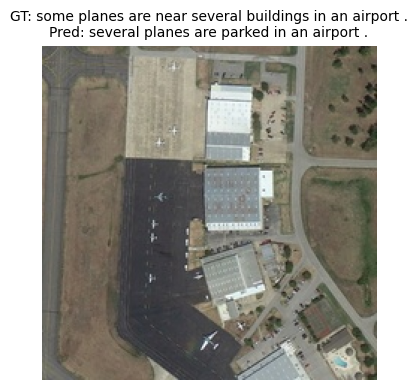

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


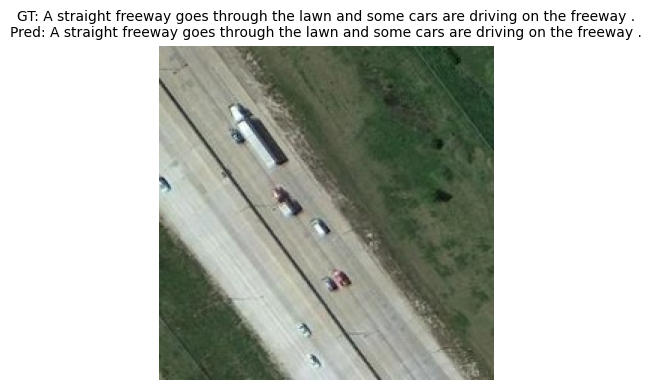

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


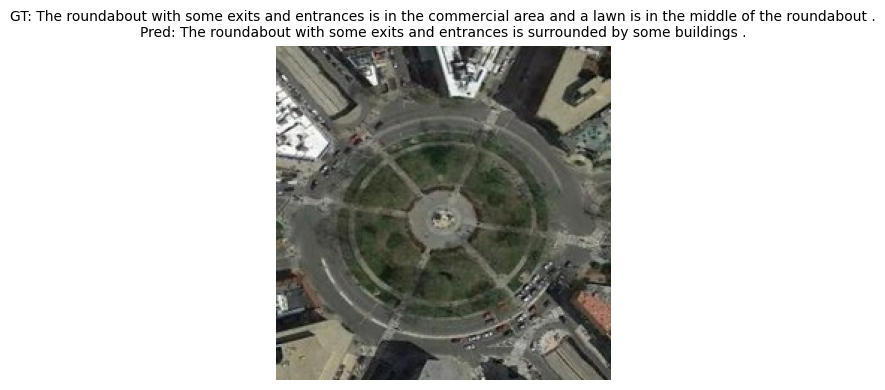

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


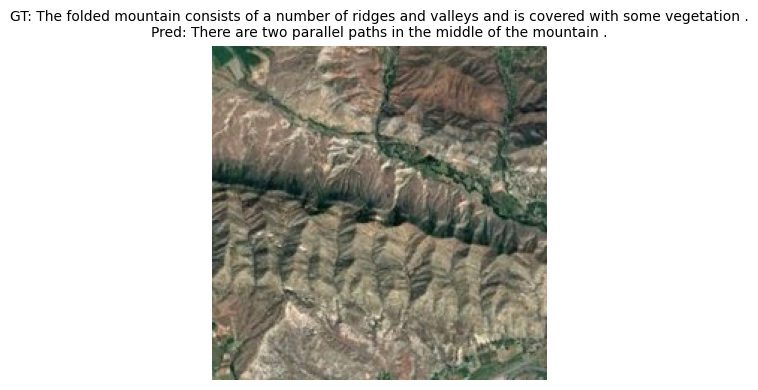

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


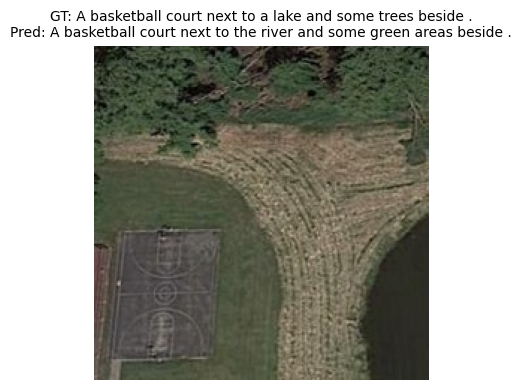

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


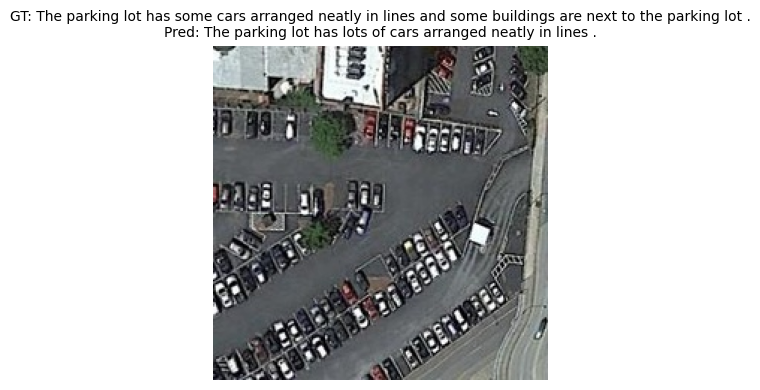

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


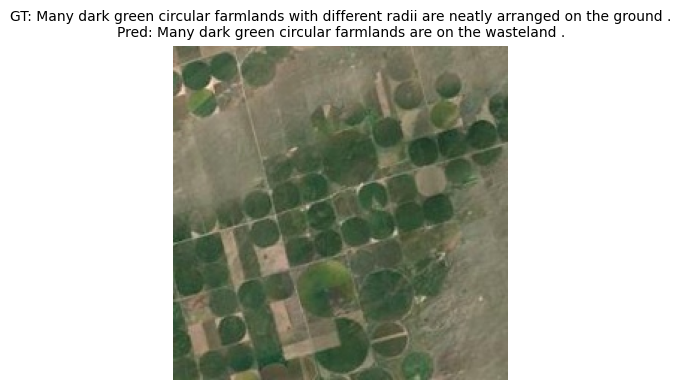

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


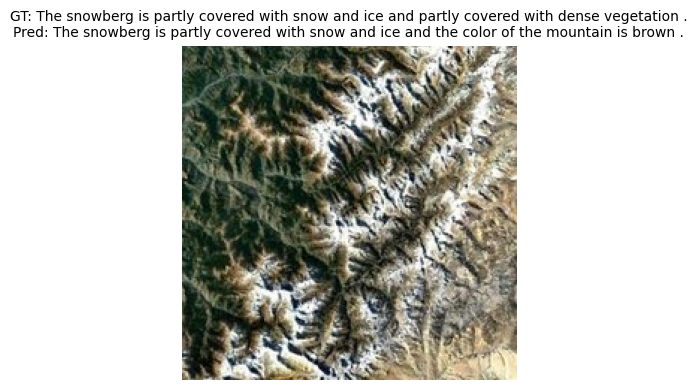

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


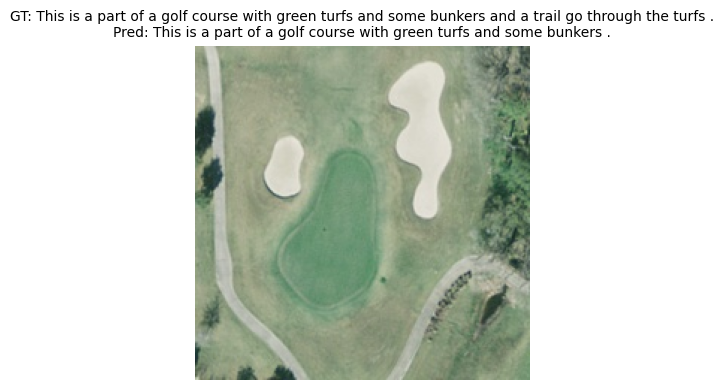

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


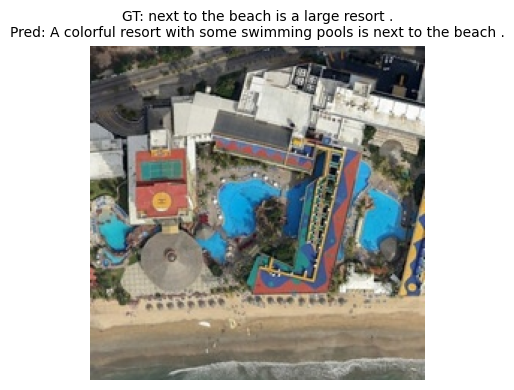

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



=== Prompt: What can you see in this satellite image? Describe in detail. ===



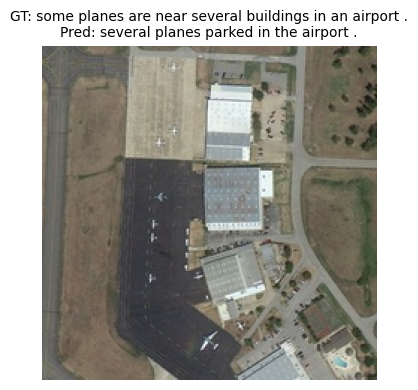

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


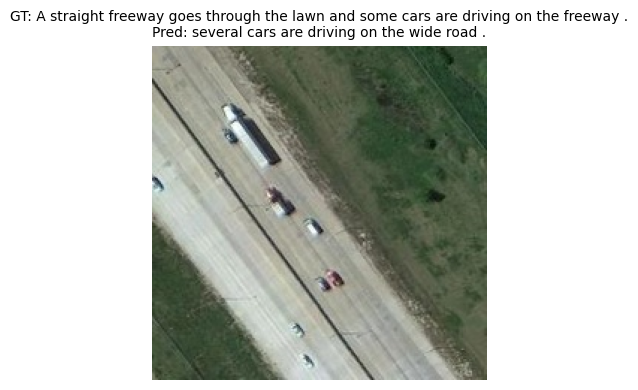

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


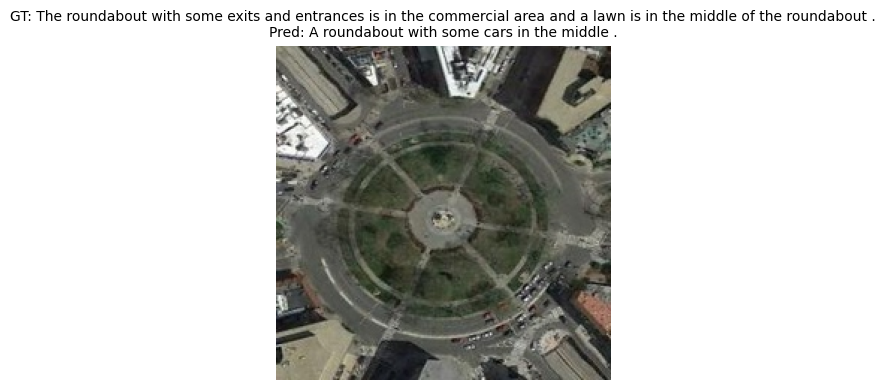

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


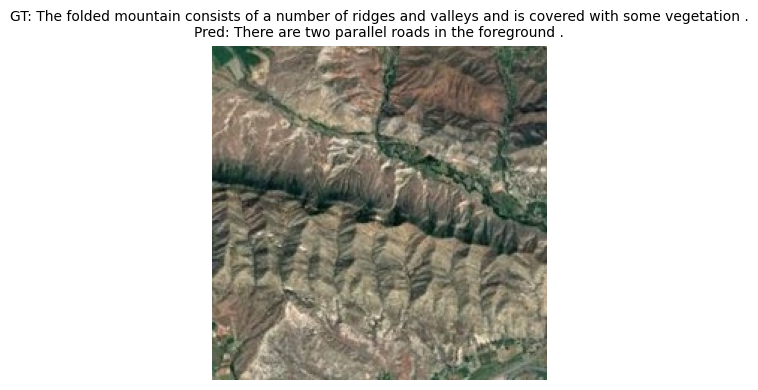

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


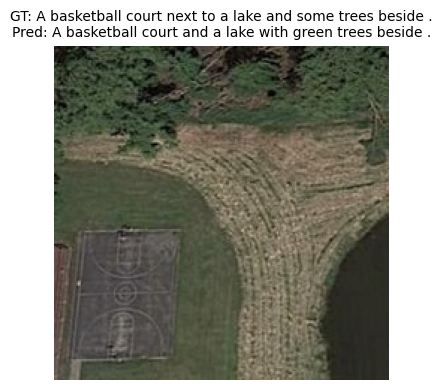

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


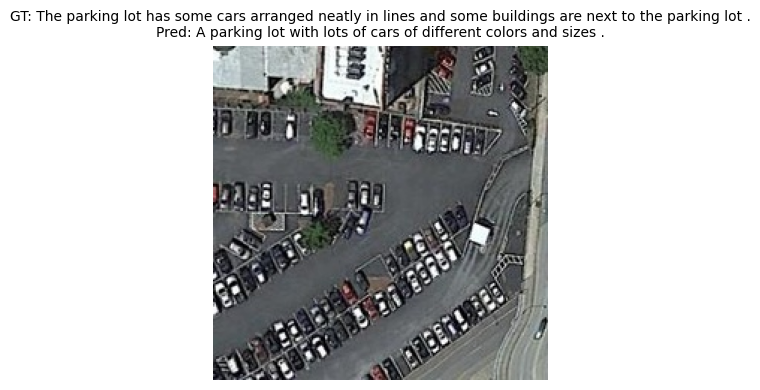

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


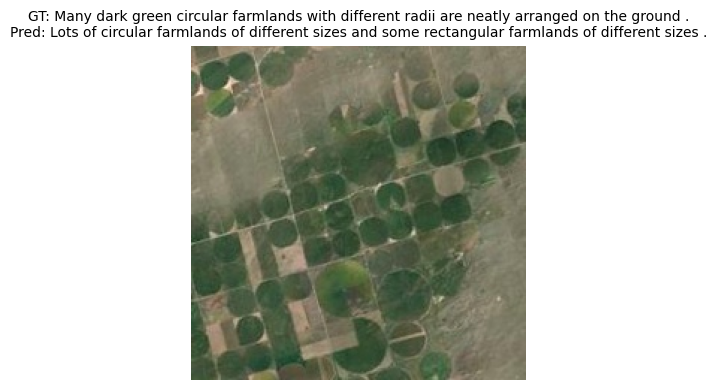

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


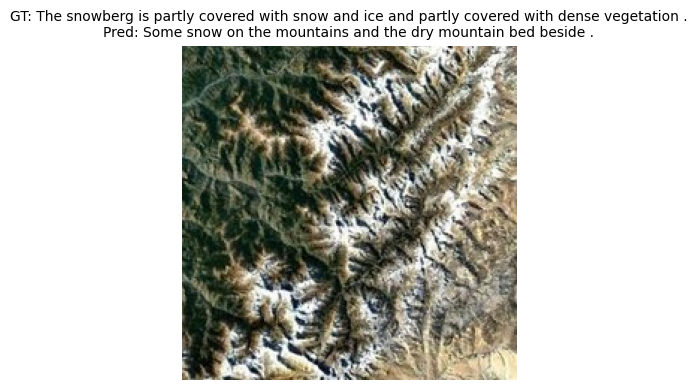

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


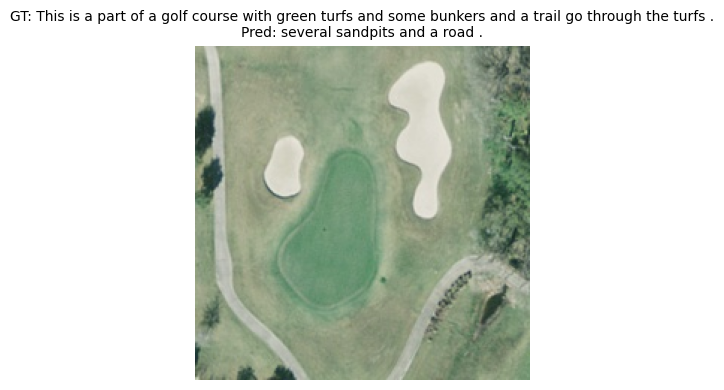

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


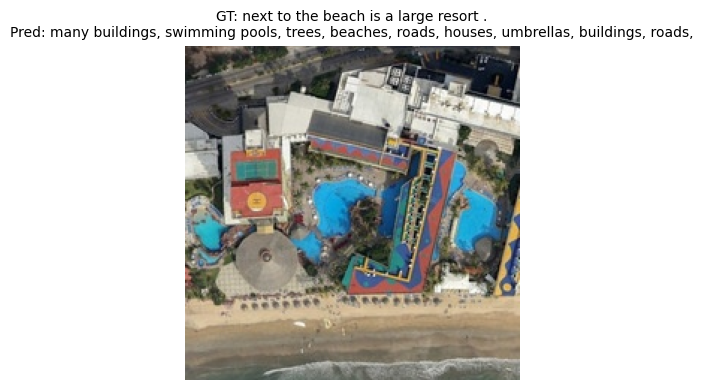

In [ ]:
# ============================
# SETUP
# ============================

import torch
import wandb
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
from huggingface_hub import login

# Login to Hugging Face and Weights & Biases
login(token="HF_API_HERE")
os.environ["WANDB_API_KEY"] = "WANDB_API_HERE"
wandb.login()

# ============================
# ✅ LOAD MODEL & PROCESSOR
# ============================
model_name = "yek-models/tier2_decoder_r8_a64_d0.05_20250611-080018_xaji"

processor = AutoProcessor.from_pretrained(model_name)
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
model.eval()

# ============================
# LOAD DATASET
# ============================
# Load from HF dataset repo
ds = load_dataset("caglarmert/full_riscm")
split = ds["train"].train_test_split(test_size=0.2, seed=42)
test_ds = split["test"]

# ============================
# CAPTION GENERATION & VISUALIZATION
# ============================
run = wandb.init(project="remote-sense-caption", name="viz_best_model", job_type="viz")

prompts = [
    "Describe this image.",
    "What can you see in this satellite image? Describe in detail."
]

for prompt in prompts:
    print(f"\n=== Prompt: {prompt} ===\n")
    for i in range(10):
        sample = test_ds[i]
        image = sample["image"].convert("RGB")  # Ensure PIL format
        ground_truth = sample["caption_1"]  # <- FIXED KEY

        # Process and generate caption
        inputs = processor(images=image, text=prompt, return_tensors="pt").to(model.device)
        output = model.generate(**inputs, max_new_tokens=20)
        decoded = processor.decode(output[0], skip_special_tokens=True)
        pred_caption = decoded[len(prompt):].strip() if decoded.startswith(prompt) else decoded.strip()

        # Plot image and captions
        plt.figure(figsize=(4, 4))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"GT: {ground_truth}\nPred: {pred_caption}", fontsize=10)
        plt.tight_layout()
        plt.show()

        # Log to WandB
        wandb.log({
            "example_index": i,
            "prompt": prompt,
            "ground_truth": ground_truth,
            "prediction": pred_caption,
            "image": wandb.Image(image, caption=f"GT: {ground_truth}\nPred: {pred_caption}")
        })

wandb.finish()


## Limitations and Lessons Learned

Throughout the Phase 3 experiments, several challenges emerged that shaped both the methodology and my understanding of efficient fine-tuning:

### Infrastructure Constraints
Despite careful planning, unreliable hardware introduced friction into the experimentation process:
- **Silent failures** due to sudden power loss, internet interruptions (for experiments run on Google Colab), or GPU memory overflows led to incomplete or corrupted runs.
- **Loss of training state** due to missing checkpoints reminded us of the importance of persistent saving and logging infrastructure, especially when training on volatile hardware.

### Memory-Efficiency Tradeoffs
- The PaliGemma model is extremely resource-intensive. Even with QLoRA 4-bit quantization and LoRA-based adapter training, it was crucial to **scale model capacity carefully**. For instance, increasing adapter rank (`r`) or injecting into too many layers often caused OOM (out-of-memory) errors unless other hyperparameters (batch size, sequence length, etc.) were simultaneously adjusted.

### Time Constraints and Incomplete Sweeps
- Some intended experiments were left **unexecuted** due to time limitations. For example, while Tier 3 included plans for full learning rate × batch size × epoch sweeps, only a subset of the training grid was explored.
- Certain commented blocks in the code still reflect **early intentions**, not finalized runs. This mismatch between design and execution is important to acknowledge.

### What I Learned
Despite these limitations, the project yielded several meaningful insights:
- **Progressive grid search works**: A tiered approach allowed us to test only 10% of the full configuration space while still identifying the best-performing model.
- **Decoder-only LoRA is highly effective** for captioning tasks where the image encoder (SigLIP) already performs well out-of-the-box.
- **Adapter coverage beats raw capacity**: Injecting LoRA into more transformer submodules (e.g., `o_proj`, `up_proj`) helped generalization more than just increasing `r` or `α`.
- **Shorter training is often enough**: The best model emerged after just 5 epochs. Longer training offered no real gain and risked overfitting.
- **Checkpointing, logging, and reproducibility tools** (Hugging Face Hub, Weights & Biases) proved essential for continuity across sessions and devices.

This experience underlined the value of resource-aware experimentation, and finding balance between robustness and brute-force search—especially with limited infrastructure.
